# $\mathcal{Note \,\, Book \, \, Overview}$
本脚本主要对原本的Vector-HaSH进行了如下的Change/Upgrade
- 为了适配“因果推理”的场景，统一定义为沿着X轴正方向为“因-果”，负方向为“果-因”。正交的Y轴方向无。
- 为了适配“因果推理”的场景，独立的因果事件被分配到一个小区域中（分块编码）
- 支持从因到果实现“概率推理”，主要依赖`class RRM_Model`，并支持`direct`（直接按概率采样）和`Boltzmann`（依照玻尔兹曼分布采样）。
- 为了实现`class RRM_Model`，`Wsp,Wps`权重矩阵的学习从直接伪逆变成了在线伪逆。

## Causal--Version Two

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numpy.random import randn, randint
from tqdm import tqdm

# 强制重建字体管理器（必须在其他 matplotlib 操作之前）
matplotlib.font_manager._load_fontmanager(try_read_cache=False)

# Import custom modules from src
import sys
import os
sys.path.append(os.path.abspath('.'))

from src.assoc_utils_np import train_gcpc
from src.assoc_utils_np_2D import gen_gbook_2d, path_integration_Wgg_2d, module_wise_NN_2d
from src.seq_utils import nonlin, sensorymap

# 完全重置所有 rcParams 到默认值
matplotlib.rcdefaults()

# 设置基本参数（不指定具体字体，使用默认 DejaVu Sans）
plt.rcParams.update({
    'figure.autolayout': True,
    'savefig.dpi': 150,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.figsize': [8, 6],
})



In [2]:
# === 1. Basic Structure Hyperparameters ===
nruns = 1
Np = 342 
lambdas = [3, 4, 5, 7] 
Ng = np.sum(np.square(lambdas))
Npos = np.prod(lambdas)

print(f"Grid Size (Npos): {Npos} x {Npos} = {Npos*Npos}")
print(f"Number of Grid Cells (Ng): {Ng}")
print(f"Number of Place Cells (Np): {Np}")

# Generate gbook
gbook = gen_gbook_2d(lambdas, Ng, Npos)
gbook_flattened = gbook.reshape(Ng, Npos*Npos)

# Generate pbook (Place Cells)
Wpg = randn(nruns, Np, Ng) 
c = 0.10     # connection probability
prune = int((1-c)*Np*Ng)
mask = np.ones((Np, Ng))
mask[randint(low=0, high=Np, size=prune), randint(low=0, high=Ng, size=prune)] = 0
Wpg = np.multiply(mask, Wpg)
thresh = 2.0  
pbook = nonlin(np.einsum('ijk,klm->ijlm', Wpg, gbook), thresh=thresh)  
pbook_flattened = pbook.reshape(nruns, Np, Npos*Npos)

# === 2. Causal Model Hyperparameters ===
C = 50          # Number of Cause events
k = 3           # Effect capacity parameter
max_effects = 2 * k + 1
print(f"Max effects per cause: {max_effects}")

# Block dimensions for allocation
block_height = 6
block_width = 2 * k + 1

Grid Size (Npos): 420 x 420 = 176400
Number of Grid Cells (Ng): 99
Number of Place Cells (Np): 342
Max effects per cause: 7


In [3]:
# === Helper Functions ===

def flat_idx(x, y, Npos=Npos):
    """Convert 2D grid coordinates to 1D flattened index."""
    return int(x * Npos + y)

def get_pvec(x, y, pbook_flattened=pbook_flattened):
    """Retrieve the Place Cell vector for a given coordinate."""
    return pbook_flattened[0, :, flat_idx(x, y)]

def rls_step(W, theta, a, y):
    """
    Recursive Least Squares (RLS) update step.
    """
    a = np.asarray(a).reshape(-1, 1)
    y = np.asarray(y).reshape(-1, 1)

    # Prediction before update
    pred_before = W @ a
    err_before = y - pred_before

    # Gain vector
    denom = 1.0 + (a.T @ theta @ a).item()
    bk = (theta @ a) / denom

    # Update covariance matrix inverse (theta)
    theta_new = theta - (theta @ a @ bk.T)

    # Update weights
    W_new = W + (err_before @ bk.T)
    
    pred_after = W_new @ a
    err_after = y - pred_after
    
    return W_new, theta_new, float(np.linalg.norm(bk)), float(np.linalg.norm(err_before)), float(np.linalg.norm(err_after))

def make_sparse_vec(N, k_sparse, rng):
    """Generate a random sparse vector."""
    v = np.zeros(N, dtype=float)
    idx = rng.choice(N, size=k_sparse, replace=False)
    v[idx] = rng.choice([-1.0, 1.0], size=k_sparse)
    v /= (np.linalg.norm(v) + 1e-12)
    return v

In [4]:
# === RRM (Relevance-Rate Matrix) Implementation ===

class RRM_Model:
    def __init__(self, max_effects, learning_rate=0.1, decay=0.01, T=0.5):
        self.max_effects = max_effects
        self.eta = learning_rate
        self.lam = decay
        self.T = T  # Temperature for Boltzmann sampling
        # Dictionary to store weights for each cause. 
        # Key: cause_id (int), Value: np.array of shape (max_effects,)
        self.weights = {} 
        self.counts = {} # For debugging/verification

    def get_weights(self, cause_id):
        if cause_id not in self.weights:
            # Initialize with small random values or zeros
            self.weights[cause_id] = np.zeros(self.max_effects)
            self.counts[cause_id] = np.zeros(self.max_effects)
        return self.weights[cause_id]

    def update(self, cause_id, effect_slot_idx, x_c=1.0, y_o=1.0):
        """
        Hebbian update: dw = eta * x * y - lambda * w
        """
        w = self.get_weights(cause_id)
        
        # Update rule
        # We update the specific slot that was active
        # w[i] += eta * x_c * y_o (if i == effect_slot_idx) - lambda * w[i]
        
        # Vectorized update
        # y_vec is 1-hot at effect_slot_idx
        y_vec = np.zeros(self.max_effects)
        y_vec[effect_slot_idx] = y_o
        
        delta_w = self.eta * x_c * y_vec - self.lam * w
        self.weights[cause_id] += delta_w
        
        # Keep weights non-negative? Usually yes for probabilities.
        self.weights[cause_id] = np.maximum(self.weights[cause_id], 0)
        
        self.counts[cause_id][effect_slot_idx] += 1

    def sample(self, cause_id, mode="direct"):
        """
        Sample an effect slot based on weights.
        mode: "direct" (normalize weights) or "Boltzmann" (softmax with temperature T)
        """
        w = self.get_weights(cause_id)
        
        if mode == "direct":
            total_w = np.sum(w)
            if total_w == 0:
                # Uniform if no weights learned yet
                probs = np.ones(self.max_effects) / self.max_effects
            else:
                probs = w / total_w
        elif mode == "Boltzmann":
            # Softmax: exp(w / T) / sum(exp(w / T))
            # For numerical stability, subtract max(w/T)
            # Handle case where T is very small or 0? Assuming T > 0.
            logits = w / self.T
            exp_logits = np.exp(logits - np.max(logits))
            probs = exp_logits / np.sum(exp_logits)
        else:
            raise ValueError(f"Unknown sampling mode: {mode}")
        
        return np.random.choice(self.max_effects, p=probs), probs

# Initialize with a default Temperature
rrm = RRM_Model(max_effects=max_effects, learning_rate=0.05, decay=0.001, T=1.0)

In [5]:
# === Data Generation & Layout Strategy ===
# === 支持双向因果推理：因到果 (CAUSE_TO_EFFECT) 和 果到因 (EFFECT_TO_CAUSE) ===

rng = np.random.default_rng(42)
Ns_demo = 512
k_sparse = 12

# ==================== 因果方向定义 ====================
# 定义因果方向常量
CAUSE_TO_EFFECT = 1   # 因到果: 沿 x+ 方向移动
EFFECT_TO_CAUSE = -1  # 果到因: 沿 x- 方向移动

def get_direction_name(direction):
    """获取方向的可读名称"""
    if direction == CAUSE_TO_EFFECT:
        return "Cause→Effect (x+)"
    else:
        return "Effect→Cause (x-)"

# ==================== 布局策略函数 ====================

def get_slot_coords_bidirectional(center_x, center_y, k, slot_idx, direction):
    """
    根据因果方向返回slot的坐标。
    
    对于 CAUSE_TO_EFFECT (因到果):
        - 中心事件（因）放在 (center_x, center_y)
        - 目标事件（果）放在 (center_x + 1, center_y + offset)
        - 即沿 x+ 方向移动
    
    对于 EFFECT_TO_CAUSE (果到因):
        - 中心事件（果）放在 (center_x + 1, center_y)  
        - 目标事件（因）放在 (center_x, center_y + offset)
        - 即沿 x- 方向移动
    
    Args:
        center_x, center_y: 中心位置（block的参考点）
        k: 用于计算 offset 范围的参数，max_slots = 2k+1
        slot_idx: slot 索引 (0 到 2k)
        direction: CAUSE_TO_EFFECT 或 EFFECT_TO_CAUSE
    
    Returns:
        (target_x, target_y): 目标位置坐标
    """
    # 计算 y 方向的 offset
    # slot_idx 映射: 0->0, 1->-1, 2->+1, 3->-2, 4->+2...
    if slot_idx == 0:
        offset = 0
    elif slot_idx % 2 != 0:  # 奇数: 1, 3, 5 -> -1, -2, -3
        offset = -((slot_idx + 1) // 2)
    else:  # 偶数: 2, 4, 6 -> +1, +2, +3
        offset = slot_idx // 2
    
    if direction == CAUSE_TO_EFFECT:
        # 因到果: 因在 (N, N), 果在 (N+1, N+offset)
        # center_x, center_y 是因的位置
        target_x = center_x + 1
        target_y = center_y + offset
    else:  # EFFECT_TO_CAUSE
        # 果到因: 果在 (N+1, N), 因在 (N, N+offset)
        # center_x, center_y 是参考位置，果在 center_x+1, 因在 center_x
        target_x = center_x
        target_y = center_y + offset
    
    return target_x, target_y

def get_source_coords(center_x, center_y, direction):
    """
    获取源事件（查询事件）的坐标。
    
    对于 CAUSE_TO_EFFECT: 源是因，位于 (center_x, center_y)
    对于 EFFECT_TO_CAUSE: 源是果，位于 (center_x + 1, center_y)
    """
    if direction == CAUSE_TO_EFFECT:
        return center_x, center_y
    else:  # EFFECT_TO_CAUSE
        return center_x + 1, center_y

# 保留原始函数以保持向后兼容
def get_effect_slot_coords(block_x, block_y, k, slot_idx):
    """
    Returns the (x, y) coordinates for a given effect slot index (0 to 2k).
    [原始函数 - 仅支持因到果]
    """
    if slot_idx == 0:
        offset = 0
    elif slot_idx % 2 != 0:
        offset = -((slot_idx + 1) // 2)
    else:
        offset = slot_idx // 2
    
    rel_x = 3
    rel_y = k + offset
    
    return block_x + rel_x, block_y + rel_y

# ==================== 数据生成 ====================

# 1. Generate Causes and Effects (因到果方向)
causes = []
cause_effect_map = {}  # cause_id -> list of effect dicts

for c_id in range(C):
    cause_vec = make_sparse_vec(Ns_demo, k_sparse, rng)
    causes.append(cause_vec)
    
    num_effects = rng.integers(1, max_effects + 1)
    
    effects = []
    probs = rng.dirichlet(np.ones(num_effects))
    
    for e_idx in range(num_effects):
        eff_vec = make_sparse_vec(Ns_demo, k_sparse, rng)
        effects.append({
            'id': f"C{c_id}_E{e_idx}",
            'vec': eff_vec,
            'prob': probs[e_idx],
            'slot_idx': -1
        })
    
    cause_effect_map[c_id] = effects

# 2. Generate Effects and Causes (果到因方向) - 新增
effects_list = []
effect_cause_map = {}  # effect_id -> list of cause dicts

E = 30  # 果事件数量（可以与C不同）

for e_id in range(E):
    effect_vec = make_sparse_vec(Ns_demo, k_sparse, rng)
    effects_list.append(effect_vec)
    
    num_causes = rng.integers(1, max_effects + 1)  # 一个果可以有多个因
    
    causes_for_effect = []
    probs = rng.dirichlet(np.ones(num_causes))
    
    for c_idx in range(num_causes):
        cau_vec = make_sparse_vec(Ns_demo, k_sparse, rng)
        causes_for_effect.append({
            'id': f"E{e_id}_C{c_idx}",
            'vec': cau_vec,
            'prob': probs[c_idx],
            'slot_idx': -1
        })
    
    effect_cause_map[e_id] = causes_for_effect

# ==================== 位置分配追踪器 ====================

# 因到果方向的追踪器
current_x_c2e = 0
current_y_c2e = 0
cause_locs = {}          # c_id -> (x, y) 因的位置
effect_locs = {}         # (c_id, e_idx) -> (x, y) 果的位置
cause_next_slot = {}     # c_id -> next_slot_int
cause_block_origins = {} # c_id -> (block_x, block_y)

# 果到因方向的追踪器 - 使用不同的起始区域避免重叠
# 果到因的 block 从 y = Npos // 2 开始
current_x_e2c = 0
current_y_e2c = Npos // 2
effect_locs_e2c = {}     # e_id -> (x, y) 果的位置（在果到因方向）
cause_locs_e2c = {}      # (e_id, c_idx) -> (x, y) 因的位置（在果到因方向）
effect_next_slot = {}    # e_id -> next_slot_int
effect_block_origins = {} # e_id -> (block_x, block_y)

print("Data generated for bidirectional causal reasoning.")
print(f"  - Cause to Effect (因→果): {C} causes")
print(f"  - Effect to Cause (果→因): {E} effects")
print(f"  - Direction x+ means Cause→Effect")
print(f"  - Direction x- means Effect→Cause")

Data generated for bidirectional causal reasoning.
  - Cause to Effect (因→果): 50 causes
  - Effect to Cause (果→因): 30 effects
  - Direction x+ means Cause→Effect
  - Direction x- means Effect→Cause


In [6]:
# === Online Learning Loop (支持双向因果推理) ===

# Initialize RLS matrices
Wps = np.zeros((Np, Ns_demo), dtype=float)
Wsp = np.zeros((Ns_demo, Np), dtype=float)
epsilon = 0.05
theta_ps = (1.0 / (epsilon**2)) * np.eye(Ns_demo)
theta_sp = (1.0 / (epsilon**2)) * np.eye(Np)

# ==================== 生成训练流（包含双向样本） ====================
n_samples = 5000
stream = []

# 因到果样本 (direction = CAUSE_TO_EFFECT)
for _ in range(n_samples // 2):
    c_id = rng.integers(0, C)
    effects = cause_effect_map[c_id]
    probs = [e['prob'] for e in effects]
    e_idx = rng.choice(len(effects), p=probs)
    stream.append({
        'direction': CAUSE_TO_EFFECT,
        'source_id': c_id,
        'target_idx': e_idx
    })

# 果到因样本 (direction = EFFECT_TO_CAUSE)
for _ in range(n_samples // 2):
    e_id = rng.integers(0, E)
    causes_for_eff = effect_cause_map[e_id]
    probs = [c['prob'] for c in causes_for_eff]
    c_idx = rng.choice(len(causes_for_eff), p=probs)
    stream.append({
        'direction': EFFECT_TO_CAUSE,
        'source_id': e_id,
        'target_idx': c_idx
    })

# 打乱样本顺序
rng.shuffle(stream)

print(f"Training on {len(stream)} samples (bidirectional)...")
print(f"  - Cause→Effect samples: {n_samples // 2}")
print(f"  - Effect→Cause samples: {n_samples // 2}")

# ==================== 统一的 RRM 模型 ====================
# 一个 RRM 就够了：
#   - 列表示源事件（因或果）
#   - 行表示对应的多个目标事件（果或因）的概率
# 使用 (direction, source_id) 作为 key 来区分两个方向
rrm = RRM_Model(max_effects=max_effects, learning_rate=0.05, decay=0.001, T=1.0)

def get_rrm_key(direction, source_id):
    """生成 RRM 的统一 key"""
    # 使用 tuple 或者简单的编码方式
    # 这里用 direction * 10000 + source_id 来区分
    return direction * 10000 + source_id

# ==================== 训练循环 ====================
history_err = []

for t, sample in enumerate(tqdm(stream)):
    direction = sample['direction']
    source_id = sample['source_id']
    target_idx = sample['target_idx']
    rrm_key = get_rrm_key(direction, source_id)
    
    if direction == CAUSE_TO_EFFECT:
        # ========== 因到果方向 ==========
        c_id = source_id
        e_idx = target_idx
        
        # 1. 动态分配因的位置
        if c_id not in cause_locs:
            if current_x_c2e + block_height > Npos:
                current_x_c2e = 0
                current_y_c2e += block_width
            
            if current_y_c2e + block_width > Npos // 2:  # 只使用前半部分空间
                continue
            
            # 因的位置: (block_x + 2, block_y + k)
            c_x = current_x_c2e + 2
            c_y = current_y_c2e + k
            cause_locs[c_id] = (c_x, c_y)
            cause_block_origins[c_id] = (current_x_c2e, current_y_c2e)
            
            current_x_c2e += block_height
            cause_next_slot[c_id] = 0
        
        # 2. 动态分配果的位置
        effect_obj = cause_effect_map[c_id][e_idx]
        if effect_obj['slot_idx'] == -1:
            slot = cause_next_slot[c_id]
            if slot < max_effects:
                effect_obj['slot_idx'] = slot
                cause_next_slot[c_id] += 1
                
                # 使用双向布局函数
                c_x, c_y = cause_locs[c_id]
                e_x, e_y = get_slot_coords_bidirectional(c_x, c_y, k, slot, CAUSE_TO_EFFECT)
                effect_locs[(c_id, e_idx)] = (e_x, e_y)
            else:
                continue
        
        if c_id not in cause_locs or (c_id, e_idx) not in effect_locs:
            continue
        
        # 3. 获取向量和位置
        s_c = causes[c_id]
        s_e = cause_effect_map[c_id][e_idx]['vec']
        loc_c = cause_locs[c_id]
        loc_e = effect_locs[(c_id, e_idx)]
        p_c = get_pvec(*loc_c)
        p_e = get_pvec(*loc_e)
        
        # 4. RLS 更新（绑定）
        Wps, theta_ps, _, _, _ = rls_step(Wps, theta_ps, s_c, p_c)
        Wsp, theta_sp, _, _, _ = rls_step(Wsp, theta_sp, p_c, s_c)
        Wps, theta_ps, _, _, _ = rls_step(Wps, theta_ps, s_e, p_e)
        Wsp, theta_sp, _, _, _ = rls_step(Wsp, theta_sp, p_e, s_e)
        
        # 5. RRM 更新（使用统一的 rrm）
        slot_idx = cause_effect_map[c_id][e_idx]['slot_idx']
        rrm.update(rrm_key, slot_idx, x_c=1.0, y_o=1.0)
        
    else:  # EFFECT_TO_CAUSE
        # ========== 果到因方向 ==========
        e_id = source_id
        c_idx = target_idx
        
        # 1. 动态分配果的位置
        if e_id not in effect_locs_e2c:
            if current_x_e2c + block_height > Npos:
                current_x_e2c = 0
                current_y_e2c += block_width
            
            if current_y_e2c + block_width > Npos:
                continue
            
            # 果的位置: (block_x + 3, block_y + k) - 在 x+1 位置
            block_x = current_x_e2c
            block_y = current_y_e2c
            e_x = block_x + 3  # 果在 x+1 位置
            e_y = block_y + k
            effect_locs_e2c[e_id] = (e_x, e_y)
            effect_block_origins[e_id] = (block_x, block_y)
            
            current_x_e2c += block_height
            effect_next_slot[e_id] = 0
        
        # 2. 动态分配因的位置（果到因：因在 x 方向上的负方向）
        cause_obj = effect_cause_map[e_id][c_idx]
        if cause_obj['slot_idx'] == -1:
            slot = effect_next_slot[e_id]
            if slot < max_effects:
                cause_obj['slot_idx'] = slot
                effect_next_slot[e_id] += 1
                
                # 果到因：因在果的 x- 方向
                e_x, e_y = effect_locs_e2c[e_id]
                if slot == 0:
                    offset = 0
                elif slot % 2 != 0:
                    offset = -((slot + 1) // 2)
                else:
                    offset = slot // 2
                c_x = e_x - 1
                c_y = e_y + offset
                cause_locs_e2c[(e_id, c_idx)] = (c_x, c_y)
            else:
                continue
        
        if e_id not in effect_locs_e2c or (e_id, c_idx) not in cause_locs_e2c:
            continue
        
        # 3. 获取向量和位置
        s_e = effects_list[e_id]
        s_c = effect_cause_map[e_id][c_idx]['vec']
        loc_e = effect_locs_e2c[e_id]
        loc_c = cause_locs_e2c[(e_id, c_idx)]
        p_e = get_pvec(*loc_e)
        p_c = get_pvec(*loc_c)
        
        # 4. RLS 更新（绑定）
        Wps, theta_ps, _, _, _ = rls_step(Wps, theta_ps, s_e, p_e)
        Wsp, theta_sp, _, _, _ = rls_step(Wsp, theta_sp, p_e, s_e)
        Wps, theta_ps, _, _, _ = rls_step(Wps, theta_ps, s_c, p_c)
        Wsp, theta_sp, _, _, _ = rls_step(Wsp, theta_sp, p_c, s_c)
        
        # 5. RRM 更新（使用统一的 rrm）
        slot_idx = effect_cause_map[e_id][c_idx]['slot_idx']
        rrm.update(rrm_key, slot_idx, x_c=1.0, y_o=1.0)

print("Training Complete (Bidirectional).")
print(f"  - Cause→Effect: {len(cause_locs)} causes learned")
print(f"  - Effect→Cause: {len(effect_locs_e2c)} effects learned")
print(f"  - Total RRM entries: {len(rrm.weights)}")

Training on 5000 samples (bidirectional)...
  - Cause→Effect samples: 2500
  - Effect→Cause samples: 2500


  0%|          | 21/5000 [00:00<00:25, 195.93it/s]

100%|██████████| 5000/5000 [00:22<00:00, 220.43it/s]

Training Complete (Bidirectional).
  - Cause→Effect: 50 causes learned
  - Effect→Cause: 30 effects learned
  - Total RRM entries: 80


### Inference Pipeline

In [7]:

# === 2. Comprehensive Inference & Reconstruction Analysis (双向) ===
# === 使用完整的 Vector-HASH Pipeline ===
# === s_i → p_i → g_i^{noisy} → g_i^{clean} ⇒ g_{i+1}^{clean} → p_{i+1} → s_{i+1} ===

print("\n=== Bidirectional Inference Analysis (Full Pipeline) ===")

# ==================== 初始化推理所需的额外矩阵 ====================

# Wpg_2d: Grid→Place 矩阵 (Np, Ng)，从原始 (nruns, Np, Ng) 中提取
Wpg_2d = np.squeeze(Wpg)  # (Np, Ng)
print(f"  Wpg_2d shape: {Wpg_2d.shape}")

# Wgp: Place→Grid 矩阵 (Ng, Np)，为 Wpg 的转置
Wgp = Wpg_2d.T  # (Ng, Np)
print(f"  Wgp shape: {Wgp.shape}")

# 生成 Path Integration 矩阵
Wgg_c2e = path_integration_Wgg_2d(lambdas, int(Ng), axis=0, direction=1)   # cause→effect: x+1
Wgg_e2c = path_integration_Wgg_2d(lambdas, int(Ng), axis=0, direction=-1)  # effect→cause: x-1
print(f"  Wgg_c2e shape: {Wgg_c2e.shape}")
print(f"  Wgg_e2c shape: {Wgg_e2c.shape}")

# Module 信息（用于 grid cell 清洗）
module_sizes = np.square(lambdas)  # e.g. [9, 16, 25, 49]
module_gbooks = [np.eye(int(size)) for size in module_sizes]
print(f"  module_sizes: {module_sizes}")

# ==================== 辅助函数 ====================

def cosine_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-9)

def normalize_vec(v):
    """归一化向量"""
    norm = np.linalg.norm(v)
    if norm < 1e-12:
        return v
    return v / norm

def get_vertical_shift(slot_idx):
    """Convert slot index to physical vertical displacement."""
    if slot_idx == 0:
        return 0
    if slot_idx % 2 != 0:
        return -((slot_idx + 1) // 2)
    return slot_idx // 2

# ==================== 完整 Pipeline 推理函数 ====================

def VH_infer_with_rrm(s_input, direction, rrm_key, 
                                   sampling_mode="direct"):
    """
    完整的 Vector-HASH 推理流程（含RRM采样）:
    
    s_i → p_i → g_i^{noisy} → g_i^{clean} ⇒ g_{i+1}^{clean} → p_{i+1} → s_{i+1}
    
    具体步骤：
    1. s_i → p_i (通过 Wps)
    2. p_i → g_i^{noisy} (通过 Wgp)
    3. g_i^{noisy} → g_i^{clean} (通过 module_wise_NN_2d 吸引子动力学)
    4. 从 RRM 采样一个 slot，决定 y 方向偏移
    5. Path Integration:
       - x 方向: 由 direction 决定 (cause→effect: x+1, effect→cause: x-1)
       - y 方向: 由采样的 slot 决定
    6. g_{i+1}^{clean} → p_{i+1} (通过 Wpg + nonlinearity)
    7. p_{i+1} → s_{i+1} (通过 Wsp)
    
    Args:
        s_input: 输入的 sensory 向量
        direction: CAUSE_TO_EFFECT 或 EFFECT_TO_CAUSE
        rrm_key: RRM 模型的 key
        sampling_mode: "direct", "Boltzmann" 或 "max_prob"
    
    Returns:
        (s_output, sampled_slot): 预测的 sensory 向量和采样的 slot
    """
    # 归一化输入
    s = normalize_vec(s_input)
    
    # Step 1: s_i → p_i (Sensory → Place cell)
    p_i = Wps @ s  # (Np,)
    
    # Step 2: p_i → g_i^{noisy} (Place → Grid, noisy)
    g_i_noisy = Wgp @ p_i  # (Ng,)
    
    # Step 3: g_i^{noisy} → g_i^{clean} (Grid cell 清洗，吸引子动力学)
    gin = g_i_noisy.reshape(1, -1, 1)  # (1, Ng, 1)
    g_i_clean = module_wise_NN_2d(gin, module_gbooks, module_sizes)
    g_i_clean = g_i_clean[0, :, 0]  # (Ng,)
    
    # Step 4: 从 RRM 采样一个 slot
    sampled_slot, probs = rrm.sample(rrm_key, mode=sampling_mode)
    
    # Step 5: Path Integration (在 grid 空间中进行)
    # x 方向由 direction 决定
    if direction == CAUSE_TO_EFFECT:
        Wgg_x = Wgg_c2e  # cause → effect (x+1)
    else:
        Wgg_x = Wgg_e2c  # effect → cause (x-1)
    
    # 先做 x 方向的 path integration
    g_next = Wgg_x @ g_i_clean
    
    # y 方向由 slot 决定
    delta_y = get_vertical_shift(sampled_slot)
    if delta_y != 0:
        direction_y = 1 if delta_y > 0 else -1
        Wgg_y = path_integration_Wgg_2d(lambdas, int(Ng), axis=1, direction=direction_y)
        for _ in range(abs(delta_y)):
            g_next = Wgg_y @ g_next
    
    # Step 6: g_{i+1}^{clean} → p_{i+1} (Grid → Place, with nonlinearity)
    # Path integration 后 g_next 已经是 clean 的（Wgg 是精确置换矩阵），无需再清洗
    p_next_linear = Wpg_2d @ g_next  # (Np,)
    p_next = np.maximum(0, p_next_linear - thresh)  # nonlinearity
    
    # Step 7: p_{i+1} → s_{i+1} (Place → Sensory)
    s_output = Wsp @ p_next  # (Ns_demo,)
    
    return s_output, sampled_slot

# ==================== 双向推理主函数 ====================

def run_bidirectional_inference(direction, mode="", n_queries=3, n_trials=50):
    """
    执行双向因果推理（使用完整 Vector-HASH Pipeline）。
    
    Args:
        direction: CAUSE_TO_EFFECT 或 EFFECT_TO_CAUSE
        mode: "direct" 或 "Boltzmann"
        n_queries: 查询的事件数量
        n_trials: 每个查询的试验次数
    
    完整推理流程：
        s_i → p_i → g_i^{noisy} → g_i^{clean} ⇒ g_{i+1}^{clean} → p_{i+1} → s_{i+1}
        
        1. s_i → p_i: 通过学习的 Wps 将 sensory 向量映射到 place cell
        2. p_i → g_i^{noisy}: 通过 Wgp (=Wpg^T) 将 place cell 映射到 grid cell (含噪声)
        3. g_i^{noisy} → g_i^{clean}: 通过 module_wise_NN_2d 吸引子动力学清洗
        4. 从 RRM 采样 slot → 决定 y 方向偏移
        5. Path Integration: Wgg_x @ g_clean (x方向) + Wgg_y (y方向, 由slot决定)
        6. g_{i+1}^{clean} → p_{i+1}: 通过 Wpg + nonlinearity
        7. p_{i+1} → s_{i+1}: 通过学习的 Wsp 读出 sensory 向量
    """
    direction_name = get_direction_name(direction)
    print(f"\n>>> Running Inference: {direction_name} | Mode: {mode} <<<")
    print(f"    Pipeline: s_i → p_i → g_i^noisy → g_i^clean ⇒ g_(i+1)^clean → p_(i+1) → s_(i+1)")
    
    if direction == CAUSE_TO_EFFECT:
        # 因到果：从因的 sensory 推理果
        valid_sources = [c for c in range(C) if c in cause_locs and len(cause_effect_map[c]) > 0]
        if not valid_sources:
            print("No valid causes found.")
            return
        
        test_sources = rng.choice(valid_sources, size=min(n_queries, len(valid_sources)), replace=False)
        source_data = cause_effect_map
        source_vecs = causes
        
    else:  # EFFECT_TO_CAUSE
        # 果到因：从果的 sensory 推理因
        valid_sources = [e for e in range(E) if e in effect_locs_e2c and len(effect_cause_map[e]) > 0]
        if not valid_sources:
            print("No valid effects found.")
            return
        
        test_sources = rng.choice(valid_sources, size=min(n_queries, len(valid_sources)), replace=False)
        source_data = effect_cause_map
        source_vecs = effects_list
    
    for source_id in test_sources:
        targets = source_data[source_id]
        rrm_key = get_rrm_key(direction, source_id)
        print(f"\n[Source {source_id}] (True Targets: {len(targets)})")
        
        # 真实分布
        true_probs = np.zeros(max_effects)
        target_vecs = {}
        for t in targets:
            if t['slot_idx'] >= 0:
                true_probs[t['slot_idx']] = t['prob']
                target_vecs[t['slot_idx']] = t['vec']
        
        # 追踪器
        slot_counts = np.zeros(max_effects)
        similarities = []
        success_count = 0
        
        # 获取源事件的 sensory 向量
        s_source = source_vecs[source_id]
        
        for _ in range(n_trials):
            # === 完整 Pipeline 推理 ===
            s_rec, sampled_slot = VH_infer_with_rrm(
                s_input=s_source,
                direction=direction,
                rrm_key=rrm_key,
                sampling_mode=mode
            )
            
            slot_counts[sampled_slot] += 1
            
            # 与真实目标向量比较
            if sampled_slot in target_vecs:
                s_true = target_vecs[sampled_slot]
                sim = cosine_sim(s_rec, s_true)
                similarities.append(sim)
                success_count += 1
        
        # 报告
        avg_sim = np.mean(similarities) if len(similarities) > 0 else 0.0
        print(f"  Trials: {n_trials} | Valid Navigation: {success_count}/{n_trials} ({success_count/n_trials*100:.1f}%)")
        print(f"  Avg Reconstruction Similarity (Sensory): {avg_sim:.4f}")
        
        # 对比分布
        sampled_dist = slot_counts / n_trials
        print(f"  Sampling Distribution (Top 3 True Probs):")
        sorted_slots = np.argsort(true_probs)[::-1]
        for s in sorted_slots[:3]:
            if true_probs[s] > 0:
                print(f"    Slot {s}: True={true_probs[s]:.2f} | Sampled={sampled_dist[s]:.2f}")

# === 执行双向推理测试 ===

print("\n" + "="*60)
print("CAUSE → EFFECT Direction (因→果, x+ path integration)")
print("="*60)

run_bidirectional_inference(CAUSE_TO_EFFECT, mode="direct", n_queries=3, n_trials=100)
run_bidirectional_inference(CAUSE_TO_EFFECT, mode="Boltzmann", n_queries=3, n_trials=100)

print("\n" + "="*60)
print("EFFECT → CAUSE Direction (果→因, x- path integration)")
print("="*60)

run_bidirectional_inference(EFFECT_TO_CAUSE, mode="direct", n_queries=3, n_trials=100)
run_bidirectional_inference(EFFECT_TO_CAUSE, mode="Boltzmann", n_queries=3, n_trials=100)



=== Bidirectional Inference Analysis (Full Pipeline) ===
  Wpg_2d shape: (342, 99)
  Wgp shape: (99, 342)
  Wgg_c2e shape: (99, 99)
  Wgg_e2c shape: (99, 99)
  module_sizes: [ 9 16 25 49]

CAUSE → EFFECT Direction (因→果, x+ path integration)

>>> Running Inference: Cause→Effect (x+) | Mode: direct <<<
    Pipeline: s_i → p_i → g_i^noisy → g_i^clean ⇒ g_(i+1)^clean → p_(i+1) → s_(i+1)

[Source 26] (True Targets: 1)
  Trials: 100 | Valid Navigation: 100/100 (100.0%)
  Avg Reconstruction Similarity (Sensory): 0.9803
  Sampling Distribution (Top 3 True Probs):
    Slot 0: True=1.00 | Sampled=1.00

[Source 44] (True Targets: 3)
  Trials: 100 | Valid Navigation: 100/100 (100.0%)
  Avg Reconstruction Similarity (Sensory): 0.0907
  Sampling Distribution (Top 3 True Probs):
    Slot 0: True=0.63 | Sampled=0.67
    Slot 1: True=0.28 | Sampled=0.30
    Slot 2: True=0.10 | Sampled=0.03

[Source 13] (True Targets: 1)
  Trials: 100 | Valid Navigation: 100/100 (100.0%)
  Avg Reconstruction Similarity

## $\mathcal{Visualization}$
- 此处绘制的是因果事件在 $N_{pos} \times N_{pos}$ 编码空间上占据的位置
- Though, there still exists some `layout` issues.


=== Spatial Distribution Visualization (Unified) ===
Plot Range: x=[0, 20], y=[0, 10]


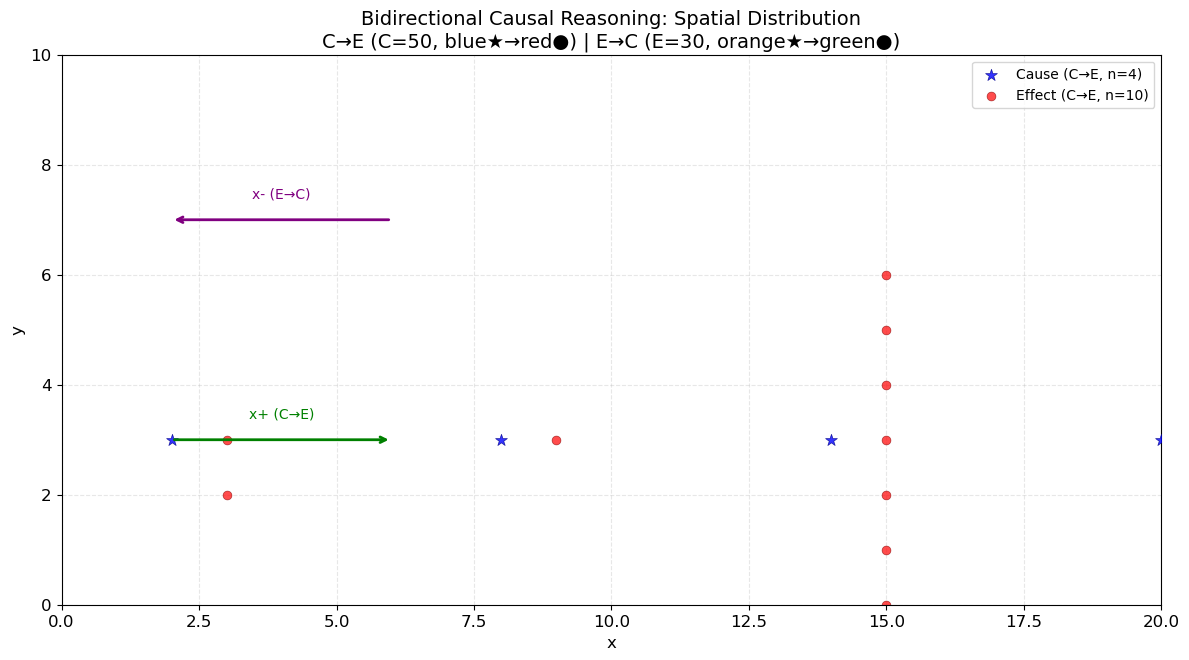

In [9]:
# === Inference & Visualization (支持双向因果推理) ===

# ==================== 可视化参数设置（手动调整） ====================
PLOT_X_MIN = 0          # x轴最小值
PLOT_X_MAX = 20        # x轴最大值
PLOT_Y_MIN = 0          # y轴最小值
PLOT_Y_MAX = 10      # y轴最大值（全范围：Npos=420）
FIG_WIDTH = 12          # 图像宽度
FIG_HEIGHT = 10         # 图像高度
MARKER_SIZE_CAUSE = 80  # 因事件标记大小
MARKER_SIZE_EFFECT = 40 # 果事件标记大小
SHOW_ARROWS = True      # 是否显示方向箭头
# ==================================================================

# 1. Spatial Visualization of Events
print("\n=== Spatial Distribution Visualization (Unified) ===")
print(f"Plot Range: x=[{PLOT_X_MIN}, {PLOT_X_MAX}], y=[{PLOT_Y_MIN}, {PLOT_Y_MAX}]")

# Calculate statistics for Cause→Effect direction
total_samples_c2e = sum([np.sum(rrm.counts[get_rrm_key(CAUSE_TO_EFFECT, c)]) 
                         for c in range(C) if get_rrm_key(CAUSE_TO_EFFECT, c) in rrm.counts])
cause_data = []
effect_data_c2e = []

for c_id in range(C):
    if c_id not in cause_locs:
        continue
    c_x, c_y = cause_locs[c_id]
    
    rrm_key = get_rrm_key(CAUSE_TO_EFFECT, c_id)
    c_count = np.sum(rrm.counts[rrm_key]) if rrm_key in rrm.counts else 0
    freq = c_count / total_samples_c2e if total_samples_c2e > 0 else 0
    cause_data.append((c_x, c_y, freq))
    
    weights = rrm.get_weights(rrm_key)
    total_w = np.sum(weights)
    
    for e_idx in range(len(cause_effect_map[c_id])):
        if (c_id, e_idx) in effect_locs:
            e_x, e_y = effect_locs[(c_id, e_idx)]
            slot_idx = cause_effect_map[c_id][e_idx]['slot_idx']
            prob = weights[slot_idx] / total_w if total_w > 0 else 0
            effect_data_c2e.append((e_x, e_y, prob))

# Calculate statistics for Effect→Cause direction
total_samples_e2c = sum([np.sum(rrm.counts[get_rrm_key(EFFECT_TO_CAUSE, e)]) 
                         for e in range(E) if get_rrm_key(EFFECT_TO_CAUSE, e) in rrm.counts])
effect_data_e2c = []
cause_data_e2c = []

for e_id in range(E):
    if e_id not in effect_locs_e2c:
        continue
    e_x, e_y = effect_locs_e2c[e_id]
    
    rrm_key = get_rrm_key(EFFECT_TO_CAUSE, e_id)
    e_count = np.sum(rrm.counts[rrm_key]) if rrm_key in rrm.counts else 0
    freq = e_count / total_samples_e2c if total_samples_e2c > 0 else 0
    effect_data_e2c.append((e_x, e_y, freq))
    
    weights = rrm.get_weights(rrm_key)
    total_w = np.sum(weights)
    
    for c_idx in range(len(effect_cause_map[e_id])):
        if (e_id, c_idx) in cause_locs_e2c:
            c_x, c_y = cause_locs_e2c[(e_id, c_idx)]
            slot_idx = effect_cause_map[e_id][c_idx]['slot_idx']
            prob = weights[slot_idx] / total_w if total_w > 0 else 0
            cause_data_e2c.append((c_x, c_y, prob))

# Convert to arrays
cause_arr = np.array(cause_data) if cause_data else np.array([]).reshape(0, 3)
effect_arr_c2e = np.array(effect_data_c2e) if effect_data_c2e else np.array([]).reshape(0, 3)
effect_arr_e2c = np.array(effect_data_e2c) if effect_data_e2c else np.array([]).reshape(0, 3)
cause_arr_e2c = np.array(cause_data_e2c) if cause_data_e2c else np.array([]).reshape(0, 3)

# ==================== 统一绘图（单张图） ====================
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))

# --- 绘制 Cause→Effect 方向的数据 ---
# 因事件（蓝色星形）
if len(cause_arr) > 0:
    mask_c = (cause_arr[:, 0] >= PLOT_X_MIN) & (cause_arr[:, 0] <= PLOT_X_MAX) & \
             (cause_arr[:, 1] >= PLOT_Y_MIN) & (cause_arr[:, 1] <= PLOT_Y_MAX)
    if np.sum(mask_c) > 0:
        ax.scatter(cause_arr[mask_c, 0], cause_arr[mask_c, 1], 
                   c='blue', marker='*', s=MARKER_SIZE_CAUSE, 
                   edgecolors='darkblue', linewidth=0.5,
                   label=f'Cause (C→E, n={np.sum(mask_c)})', alpha=0.8, zorder=3)

# 果事件（红色圆形）
if len(effect_arr_c2e) > 0:
    mask_e = (effect_arr_c2e[:, 0] >= PLOT_X_MIN) & (effect_arr_c2e[:, 0] <= PLOT_X_MAX) & \
             (effect_arr_c2e[:, 1] >= PLOT_Y_MIN) & (effect_arr_c2e[:, 1] <= PLOT_Y_MAX)
    if np.sum(mask_e) > 0:
        ax.scatter(effect_arr_c2e[mask_e, 0], effect_arr_c2e[mask_e, 1], 
                   c='red', marker='o', s=MARKER_SIZE_EFFECT, 
                   edgecolors='darkred', linewidth=0.5,
                   label=f'Effect (C→E, n={np.sum(mask_e)})', alpha=0.7, zorder=2)

# --- 绘制 Effect→Cause 方向的数据 ---
# 果事件（橙色星形）
if len(effect_arr_e2c) > 0:
    mask_e2 = (effect_arr_e2c[:, 0] >= PLOT_X_MIN) & (effect_arr_e2c[:, 0] <= PLOT_X_MAX) & \
              (effect_arr_e2c[:, 1] >= PLOT_Y_MIN) & (effect_arr_e2c[:, 1] <= PLOT_Y_MAX)
    if np.sum(mask_e2) > 0:
        ax.scatter(effect_arr_e2c[mask_e2, 0], effect_arr_e2c[mask_e2, 1], 
                   c='orange', marker='*', s=MARKER_SIZE_CAUSE, 
                   edgecolors='darkorange', linewidth=0.5,
                   label=f'Effect (E→C, n={np.sum(mask_e2)})', alpha=0.8, zorder=3)

# 因事件（绿色圆形）
if len(cause_arr_e2c) > 0:
    mask_c2 = (cause_arr_e2c[:, 0] >= PLOT_X_MIN) & (cause_arr_e2c[:, 0] <= PLOT_X_MAX) & \
              (cause_arr_e2c[:, 1] >= PLOT_Y_MIN) & (cause_arr_e2c[:, 1] <= PLOT_Y_MAX)
    if np.sum(mask_c2) > 0:
        ax.scatter(cause_arr_e2c[mask_c2, 0], cause_arr_e2c[mask_c2, 1], 
                   c='green', marker='o', s=MARKER_SIZE_EFFECT, 
                   edgecolors='darkgreen', linewidth=0.5,
                   label=f'Cause (E→C, n={np.sum(mask_c2)})', alpha=0.7, zorder=2)

# 设置坐标轴范围（先设定，避免后续注释撑大布局）
ax.set_xlim(PLOT_X_MIN, PLOT_X_MAX)
ax.set_ylim(PLOT_Y_MIN, PLOT_Y_MAX)

# 添加方向箭头（若范围过小则收缩到可见区域）
if SHOW_ARROWS:
    y_range = PLOT_Y_MAX - PLOT_Y_MIN
    arrow_y = (PLOT_Y_MIN + PLOT_Y_MAX) / 2
    arrow_x_start = PLOT_X_MIN + (PLOT_X_MAX - PLOT_X_MIN) * 0.1
    arrow_x_end = PLOT_X_MIN + (PLOT_X_MAX - PLOT_X_MIN) * 0.3
    
    # 将箭头 y 位置夹在可视范围内
    def clamp_y(y):
        return max(PLOT_Y_MIN + 0.05 * y_range, min(PLOT_Y_MAX - 0.05 * y_range, y))

    y_c2e = clamp_y(arrow_y - 0.2 * y_range)
    y_e2c = clamp_y(arrow_y + 0.2 * y_range)

    # C→E 方向箭头 (x+)
    ax.annotate('', xy=(arrow_x_end, y_c2e), xytext=(arrow_x_start, y_c2e),
                arrowprops=dict(arrowstyle='->', color='green', lw=2),
                annotation_clip=True)
    ax.text((arrow_x_start + arrow_x_end) / 2, y_c2e + 0.04 * y_range, 'x+ (C→E)', 
            fontsize=10, color='green', ha='center', clip_on=True)
    
    # E→C 方向箭头 (x-)
    ax.annotate('', xy=(arrow_x_start, y_e2c), xytext=(arrow_x_end, y_e2c),
                arrowprops=dict(arrowstyle='->', color='purple', lw=2),
                annotation_clip=True)
    ax.text((arrow_x_start + arrow_x_end) / 2, y_e2c + 0.04 * y_range, 'x- (E→C)', 
            fontsize=10, color='purple', ha='center', clip_on=True)

# 添加分隔线（只在可视范围内显示）
mid_y = Npos // 2
if PLOT_Y_MIN <= mid_y <= PLOT_Y_MAX:
    ax.axhline(y=mid_y, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.text(PLOT_X_MAX - 0.5, mid_y + 0.02 * (PLOT_Y_MAX - PLOT_Y_MIN),
            f'y={mid_y} (boundary)', fontsize=9, color='gray', ha='right', clip_on=True)

# 设置坐标轴
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title(f'Bidirectional Causal Reasoning: Spatial Distribution\n'
             f'C→E (C={C}, blue★→red●) | E→C (E={E}, orange★→green●)', fontsize=14)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, linestyle='--', alpha=0.3)
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


###  Policy Landscape Visualization


=== Policy Landscape Visualization ===
Visualizing Policy Landscape for Cause 1...


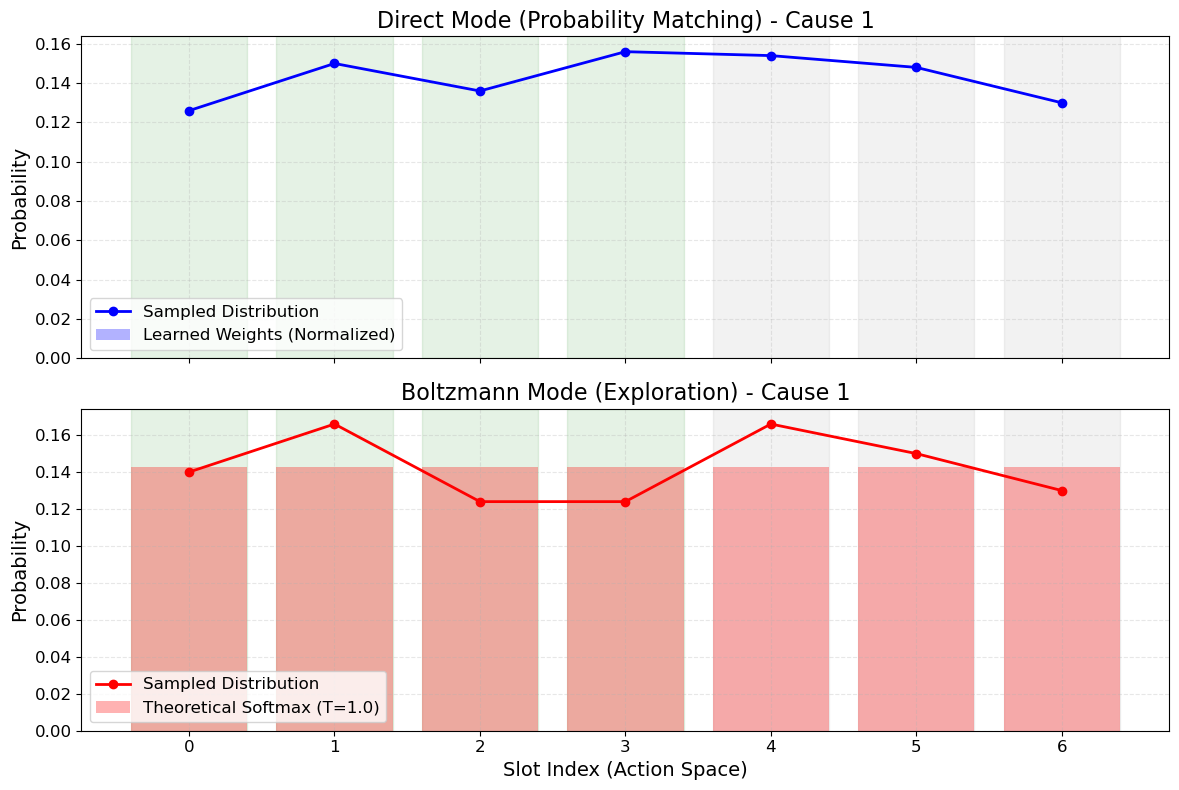

In [ ]:
# === Policy Landscape Visualization ===
print("\n=== Policy Landscape Visualization ===")

def plot_policy_landscape(c_id, n_trials=500):
    """
    Visualizes the 'Policy Landscape' for a specific cause.
    Compares Direct (Probability Matching) vs Boltzmann (Exploration) sampling.
    """
    if c_id not in cause_locs:
        print(f"Cause {c_id} not found in learned map.")
        return

    # 1. Get Ground Truth & RRM Weights
    true_probs = np.zeros(max_effects)
    valid_slots = []
    for e in cause_effect_map[c_id]:
        true_probs[e['slot_idx']] = e['prob']
        valid_slots.append(e['slot_idx'])
        
    weights = rrm.get_weights(c_id)
    norm_weights = weights / np.sum(weights) if np.sum(weights) > 0 else weights

    # 2. Run Sampling Experiments
    # Direct Mode
    counts_direct = np.zeros(max_effects)
    for _ in range(n_trials):
        s, _ = rrm.sample(c_id, mode="direct")
        counts_direct[s] += 1
    dist_direct = counts_direct / n_trials

    # Boltzmann Mode
    counts_boltz = np.zeros(max_effects)
    for _ in range(n_trials):
        s, _ = rrm.sample(c_id, mode="Boltzmann")
        counts_boltz[s] += 1
    dist_boltz = counts_boltz / n_trials

    # 3. Plotting
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    slots = np.arange(max_effects)
    
    # Helper for background shading
    def add_background(ax):
        # Shade valid slots green, invalid gray
        for s in slots:
            if s in valid_slots:
                ax.axvspan(s - 0.4, s + 0.4, color='green', alpha=0.1)
            else:
                ax.axvspan(s - 0.4, s + 0.4, color='gray', alpha=0.1)
    
    # Plot 1: Direct Mode
    ax0 = axes[0]
    add_background(ax0)
    ax0.bar(slots, norm_weights, color='blue', alpha=0.3, label='Learned Weights (Normalized)')
    ax0.plot(slots, dist_direct, 'o-', color='blue', linewidth=2, label='Sampled Distribution')
    ax0.set_ylabel('Probability')
    ax0.set_title(f'Direct Mode (Probability Matching) - Cause {c_id}')
    ax0.legend()
    ax0.grid(True, linestyle='--', alpha=0.3)

    # Plot 2: Boltzmann Mode
    ax1 = axes[1]
    add_background(ax1)
    # Show the "Softmaxed" weights as theoretical curve
    logits = weights / rrm.T
    exp_logits = np.exp(logits - np.max(logits))
    softmax_probs = exp_logits / np.sum(exp_logits)
    
    ax1.bar(slots, softmax_probs, color='red', alpha=0.3, label=f'Theoretical Softmax (T={rrm.T})')
    ax1.plot(slots, dist_boltz, 'o-', color='red', linewidth=2, label='Sampled Distribution')
    ax1.set_ylabel('Probability')
    ax1.set_xlabel('Slot Index (Action Space)')
    ax1.set_title(f'Boltzmann Mode (Exploration) - Cause {c_id}')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Find a cause with multiple effects for interesting visualization
complex_causes = [c for c in range(C) if len(cause_effect_map[c]) >= 2]
if complex_causes:
    target_c = complex_causes[0]
    print(f"Visualizing Policy Landscape for Cause {target_c}...")
    plot_policy_landscape(target_c)
else:
    print("No complex causes found to visualize.")